# Welcome to this lovely notebook. This is the extention of the notebook EDA with data preprocessing and modeling parts (XGBoost)

## In this notebook we are going to implement the following:

1. Runnig the base version of XGBoost
2. After running the base version of the model, we'll run a check on which downsampled dataset is better and try to improve the results by finding better hyper parameters

## Importing all required libraries

In [1]:
#importing all the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import shap
from datetime import datetime

# Set the option to display all columns
pd.set_option('display.max_columns', None)

# metrics
from sklearn.metrics import classification_report

# Encoding
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

# Machine Learning - Preparation
from sklearn.model_selection import train_test_split

# Machine Learning - Algorithm
from xgboost import XGBClassifier

C:\Users\atans\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1 Let's get the data

In [2]:
train = pd.read_csv('fraudTrain.csv', index_col=0)
test = pd.read_csv('fraudTest.csv', index_col=0)

## 2 Let's split the data

In [3]:
X_train = train.drop(columns=['is_fraud'])
y_train = train['is_fraud']

X_test = test.drop(columns=['is_fraud'])
y_test = test['is_fraud']

## 3 Creating additional columns which will be used

The columns that have to be added:
1. Day of week
2. Month
3. Hour
4. Age of user

In [5]:
current_date = datetime.now()

for dataset in [X_train, X_test]:
    dataset['trans_date_trans_time'] = pd.to_datetime(dataset['trans_date_trans_time'])
    dataset['dob'] = pd.to_datetime(dataset['dob'])
    dataset['day_of_week'] = dataset['trans_date_trans_time'].dt.day_name()
    dataset['month'] = dataset['trans_date_trans_time'].dt.month
    dataset['hour'] = dataset['trans_date_trans_time'].dt.hour
    dataset['age'] =dataset['dob'].apply(lambda x: current_date.year - x.year - ((current_date.month, current_date.day) < (x.month, x.day)))

## 4 Dropping the columns we are not going to use

In [6]:
X_train.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'day_of_week', 'month', 'hour', 'age'],
      dtype='object')

In [6]:
for dataset in [X_train, X_test]:
    dataset.drop(['trans_date_trans_time', 'cc_num', 'first', 'last', 'street',\
                            'zip', 'dob', 'trans_num', 'unix_time'], axis=1, inplace=True)

## 4.1 Encoding categorical features and running 'trial' models

In [7]:
X_train.columns

Index(['merchant', 'category', 'amt', 'gender', 'city', 'state', 'lat', 'long',
       'city_pop', 'job', 'merch_lat', 'merch_long', 'day_of_week', 'month',
       'hour', 'age'],
      dtype='object')

In [8]:
%%time
# Step 1: Separate categorical and numerical columns
categorical_columns = ['merchant', 'category', 'gender', 'city', 'state', 'job', 'day_of_week']
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 2: Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')  # drop='first' to avoid multicollinearity

# Step 3: Apply OneHotEncoder to the categorical columns in X_train (fit the encoder)
encoded_categorical_train = encoder.fit_transform(X_train[categorical_columns])

# Step 4: Convert the encoded categorical data back to a DataFrame for X_train
encoded_df_train = pd.DataFrame(encoded_categorical_train, columns=encoder.get_feature_names_out(categorical_columns))

# Step 5: Concatenate the numerical columns with the encoded categorical columns for X_train
X_train_encoded = pd.concat([X_train[numerical_columns].reset_index(drop=True), encoded_df_train.reset_index(drop=True)], axis=1)

# Now apply the same transformation to the test data (use transform instead of fit_transform)
encoded_categorical_test = encoder.transform(X_test[categorical_columns])

# Convert the encoded categorical data back to a DataFrame for X_test
encoded_df_test = pd.DataFrame(encoded_categorical_test, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the numerical columns with the encoded categorical columns for X_test
X_test_encoded = pd.concat([X_test[numerical_columns].reset_index(drop=True), encoded_df_test.reset_index(drop=True)], axis=1)

C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


CPU times: total: 51.5 s
Wall time: 2min 40s


### 5.1 Testing XGBoost with log_loss eval_metric

In [9]:
%%time
# Step 1: Initialize the XGBoost Classifier
model_5 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')  # You can set any other hyperparameters here

# Step 2: Train the model on the training data
model_5.fit(X_train_encoded, y_train)

# Step 3: Predict on the training data
y_train_pred = model_5.predict(X_train_encoded)

# Step 4: Predict on the test data
y_test_pred = model_5.predict(X_test_encoded)

# Step 5: Generate the classification report for training data
print("Classification Report for Training Data:")
print(classification_report(y_train, y_train_pred))

# Step 6: Generate the classification report for test data
print("\nClassification Report for Test Data:")
print(classification_report(y_test, y_test_pred))

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.88      0.64      0.74      7506

    accuracy                           1.00   1296675
   macro avg       0.94      0.82      0.87   1296675
weighted avg       1.00      1.00      1.00   1296675


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.77      0.52      0.62      2145

    accuracy                           1.00    555719
   macro avg       0.88      0.76      0.81    555719
weighted avg       1.00      1.00      1.00    555719

CPU times: total: 36min 42s
Wall time: 4min


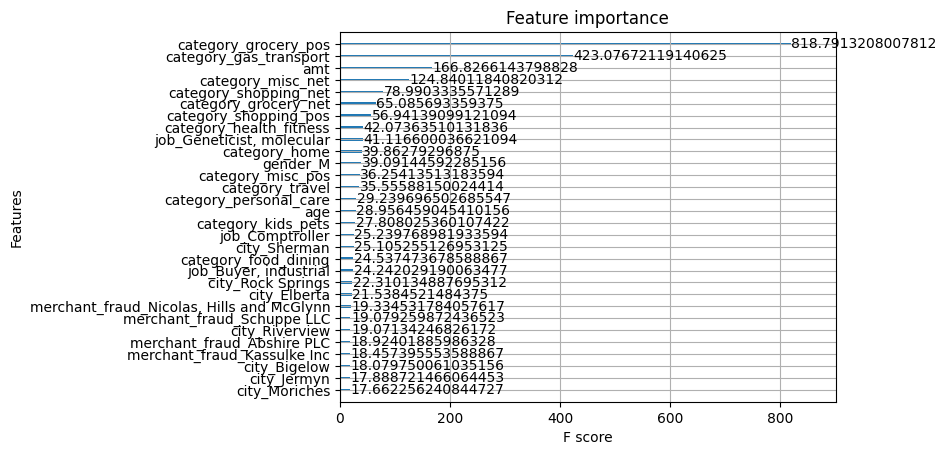

In [13]:
import xgboost
# Plot feature importance
xgboost.plot_importance(model_5, importance_type='gain', max_num_features=30)  # You can change to 'weight' or 'cover'
plt.show()

In [14]:
#Looks pretty cool!
#The results look quite good! for the very first run

In [15]:
# Now we can try a few more things like:
# 1. We can try to drop longitudes and latitudes and check how they affect the results
# 2. We can try to remove job, city, merchant (columns with high cordinality)
# 3. We can try to downsample the train data and see if it improves the results
# 4. We can try to play with hyper parameters

### 5.2 Getting all the possible features, apart from long and lat and testing XGBoost with logloss eval_metric

In [9]:
%%time
X_train_encoded_5_2 = X_train_encoded.drop(['lat', 'long', 'merch_lat', 'merch_long'], axis=1)
X_test_encoded_5_2 = X_test_encoded.drop(['lat', 'long', 'merch_lat', 'merch_long'], axis=1)

CPU times: total: 13.7 s
Wall time: 1min 16s


In [10]:
%%time
# Step 1: Initialize the XGBoost Classifier
model_5_2 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')  # You can set any other hyperparameters here

# Step 2: Train the model on the training data
model_5_2.fit(X_train_encoded_5_2, y_train)

# Step 3: Predict on the training data
y_train_pred = model_5_2.predict(X_train_encoded_5_2)

# Step 4: Predict on the test data
y_test_pred = model_5_2.predict(X_test_encoded_5_2)

# Step 5: Generate the classification report for training data
print("Classification Report for Training Data:")
print(classification_report(y_train, y_train_pred))

# Step 6: Generate the classification report for test data
print("\nClassification Report for Test Data:")
print(classification_report(y_test, y_test_pred))

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.87      0.64      0.74      7506

    accuracy                           1.00   1296675
   macro avg       0.93      0.82      0.87   1296675
weighted avg       1.00      1.00      1.00   1296675


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.76      0.52      0.62      2145

    accuracy                           1.00    555719
   macro avg       0.88      0.76      0.81    555719
weighted avg       1.00      1.00      1.00    555719

CPU times: total: 38min 12s
Wall time: 4min 31s


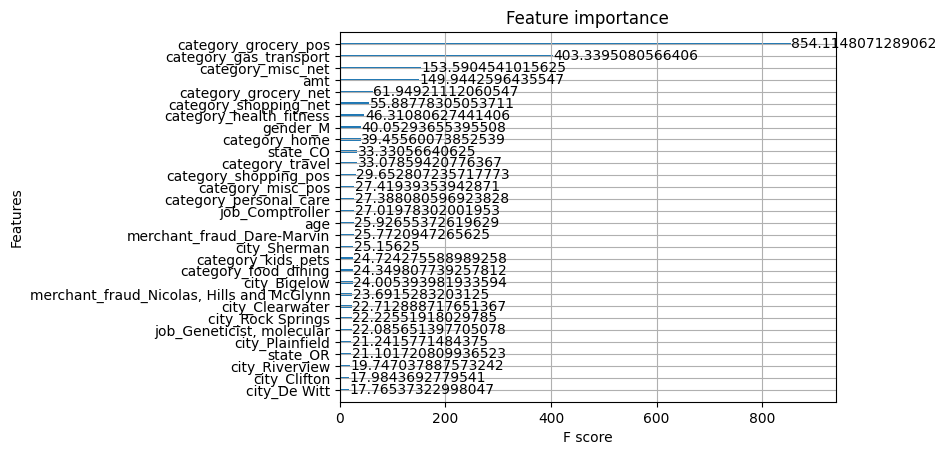

CPU times: total: 141 ms
Wall time: 701 ms


In [11]:
%%time
import xgboost
# Plot feature importance
xgboost.plot_importance(model_5_2, importance_type='gain', max_num_features=30)  # You can change to 'weight' or 'cover'
plt.show()

##### Observation and a colnclusion:
as we see, the model uses quite all the categorical features (job, gender, city, state, category, merchant), Therefore, we are not going to remove the features.

### 5.3 Trying downsampling of not fraudulent rows of train data all the possible features, apart from long and lat and testing XGBoost with logloss eval_metric

In [5]:
%%time
X_train_5_3 = X_train.drop(['trans_date_trans_time', 'cc_num', 'first', 'last', 'street',\
                            'zip', 'dob', 'trans_num', 'unix_time','lat', 'long', 'merch_lat', 'merch_long'], axis=1)
X_test_5_3 = X_test.drop(['trans_date_trans_time', 'cc_num', 'first', 'last', 'street',\
                            'zip', 'dob', 'trans_num', 'unix_time','lat', 'long', 'merch_lat', 'merch_long'], axis=1)

CPU times: total: 15.6 ms
Wall time: 96.9 ms


In [6]:
%%time
# Step 1: Separate categorical and numerical columns
categorical_columns = ['merchant', 'category', 'gender', 'city', 'state', 'job', 'day_of_week']
numerical_columns = X_train_5_3.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 2: Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')  # drop='first' to avoid multicollinearity

# Step 3: Apply OneHotEncoder to the categorical columns in X_train (fit the encoder)
encoded_categorical_train = encoder.fit_transform(X_train_5_3[categorical_columns])

# Step 4: Convert the encoded categorical data back to a DataFrame for X_train
encoded_df_train = pd.DataFrame(encoded_categorical_train, columns=encoder.get_feature_names_out(categorical_columns))

# Step 5: Concatenate the numerical columns with the encoded categorical columns for X_train
X_train_encoded_5_3 = pd.concat([X_train_5_3[numerical_columns].reset_index(drop=True), encoded_df_train.reset_index(drop=True)], axis=1)

# Now apply the same transformation to the test data (use transform instead of fit_transform)
encoded_categorical_test = encoder.transform(X_test_5_3[categorical_columns])

# Convert the encoded categorical data back to a DataFrame for X_test
encoded_df_test = pd.DataFrame(encoded_categorical_test, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the numerical columns with the encoded categorical columns for X_test
X_test_encoded_5_3 = pd.concat([X_test_5_3[numerical_columns].reset_index(drop=True), encoded_df_test.reset_index(drop=True)], axis=1)

C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


CPU times: total: 51.5 s
Wall time: 2min 28s


### Running a loop with various downsample options, we also want to save all the features that the model used, in order to filter our encoded df for it to be lighter as the input

In [7]:
%%time
# Reset the indices to align them
X_train_encoded_5_3 = X_train_encoded_5_3.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Step 1: Separate majority class (0s) and minority class (1s)
X_train_encoded_0 = X_train_encoded_5_3[y_train == 0]
X_train_encoded_1 = X_train_encoded_5_3[y_train == 1]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]


for frac in [1.0, 0.8, 0.5, 0.25, 0.1, 0.05]:

    # Step 2: Downsample the majority class (0s) by frac
    # Downsample X_train_encoded_0 and use its indices to select the corresponding rows from y_train_0
    X_train_0_downsampled = X_train_encoded_0.sample(frac=frac, random_state=42)
    y_train_0_downsampled = y_train_0.loc[X_train_0_downsampled.index]  # Use the same indices for y_train

    # Step 3: Concatenate the downsampled majority class with the minority class
    X_train_downsampled = pd.concat([X_train_0_downsampled, X_train_encoded_1])
    y_train_downsampled = pd.concat([y_train_0_downsampled, y_train_1])

    # Step 4: Shuffle the dataset to mix the downsampled rows
    X_train_downsampled_5_3 = X_train_downsampled.sample(frac=1, random_state=42)
    y_train_downsampled_5_3 = y_train_downsampled.loc[X_train_downsampled_5_3.index]  # Align y_train after shuffling

    # Step 5: Initialize the XGBoost Classifier
    model_5_3 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')  # You can set any other hyperparameters here

    # Step 6: Train the model on the training data
    model_5_3.fit(X_train_downsampled_5_3, y_train_downsampled_5_3)

    # Step 7: Predict on the training data
    y_train_pred = model_5_3.predict(X_train_downsampled_5_3)

    # Step 8: Predict on the test data
    y_test_pred = model_5_3.predict(X_test_encoded_5_3)

    print('\n')
    print(f'This is a set of results for frac: {frac*100} %')
    print('\n')
    #print how many features were used:
    feature_importance = model_5_3.get_booster().get_score(importance_type='gain')
    sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    top_features = [feature for feature, importance in sorted_importance]
    print(f"Num of features used: {len(top_features)}")


    # Step 9: Generate the classification report for training data
    print("Classification Report for Training Data:")
    print(classification_report(y_train_downsampled_5_3, y_train_pred))

    # Step 10: Generate the classification report for test data
    print("\nClassification Report for Test Data:")
    print(classification_report(y_test, y_test_pred))



This is a set of results for frac: 100.0 %


Num of features used: 334
Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.87      0.63      0.73      7506

    accuracy                           1.00   1296675
   macro avg       0.93      0.82      0.87   1296675
weighted avg       1.00      1.00      1.00   1296675


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.76      0.52      0.62      2145

    accuracy                           1.00    555719
   macro avg       0.88      0.76      0.81    555719
weighted avg       1.00      1.00      1.00    555719



This is a set of results for frac: 80.0 %


Num of features used: 338
Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00   

## So we see the following:
1. Latitude and Longitude columns are redundant
2. It terms of imbalanced data, training XGBoost on 50% of train data + all fraud gives pretty balanced results

In [19]:
#So interestingly enough, we can see that in the current set of settings, only 324 out of 2155 features were used

### 5.4 Trying to use target encoder and basically running 5.3

In [15]:
%%time
X_train_5_4 = X_train.drop(['trans_date_trans_time', 'cc_num', 'first', 'last', 'street',\
                            'zip', 'dob', 'trans_num', 'unix_time','lat', 'long', 'merch_lat', 'merch_long'], axis=1)
X_test_5_4 = X_test.drop(['trans_date_trans_time', 'cc_num', 'first', 'last', 'street',\
                            'zip', 'dob', 'trans_num', 'unix_time','lat', 'long', 'merch_lat', 'merch_long'], axis=1)

CPU times: total: 93.8 ms
Wall time: 152 ms


In [16]:
# Step 1: Separate categorical columns for target encoding and OneHotEncoding
target_encoding_columns = ['merchant', 'city', 'job']
one_hot_encoding_columns = ['category', 'gender', 'day_of_week', 'state']
numerical_columns = X_train_5_4.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 2: Initialize TargetEncoder for the specified columns
target_encoder = ce.TargetEncoder(cols=target_encoding_columns)

# Step 3: Apply TargetEncoder to the specified categorical columns in X_train
X_train_encoded_target = target_encoder.fit_transform(X_train_5_4[target_encoding_columns], y_train)

# Step 4: Apply OneHotEncoder to the other categorical columns in X_train
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
encoded_categorical_train = encoder.fit_transform(X_train_5_4[one_hot_encoding_columns])

# Convert the encoded categorical data back to a DataFrame for X_train
encoded_df_train = pd.DataFrame(encoded_categorical_train, columns=encoder.get_feature_names_out(one_hot_encoding_columns))

# Step 5: Concatenate the numerical columns, target-encoded columns, and one-hot-encoded columns for X_train
X_train_encoded_5_4 = pd.concat([
    X_train_5_4[numerical_columns].reset_index(drop=True),  # Numerical columns
    X_train_encoded_target.reset_index(drop=True),          # Target-encoded columns
    encoded_df_train.reset_index(drop=True)                 # One-hot-encoded columns
], axis=1)

# Now apply the same transformation to the test data
X_test_encoded_target = target_encoder.transform(X_test_5_4[target_encoding_columns])

# Apply OneHotEncoder to the other categorical columns in X_test
encoded_categorical_test = encoder.transform(X_test_5_4[one_hot_encoding_columns])

# Convert the encoded categorical data back to a DataFrame for X_test
encoded_df_test = pd.DataFrame(encoded_categorical_test, columns=encoder.get_feature_names_out(one_hot_encoding_columns))

# Concatenate the numerical columns, target-encoded columns, and one-hot-encoded columns for X_test
X_test_encoded_5_4 = pd.concat([
    X_test_5_4[numerical_columns].reset_index(drop=True),   # Numerical columns
    X_test_encoded_target.reset_index(drop=True),           # Target-encoded columns
    encoded_df_test.reset_index(drop=True)                  # One-hot-encoded columns
], axis=1)


In [19]:
%%time
# Reset the indices to align them
X_train_encoded_5_4 = X_train_encoded_5_4.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Step 1: Separate majority class (0s) and minority class (1s)
X_train_encoded_0 = X_train_encoded_5_4[y_train == 0]
X_train_encoded_1 = X_train_encoded_5_4[y_train == 1]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]


for frac in [1.0, 0.8, 0.5, 0.25, 0.1, 0.05]:

    # Step 2: Downsample the majority class (0s) by frac
    # Downsample X_train_encoded_0 and use its indices to select the corresponding rows from y_train_0
    X_train_0_downsampled = X_train_encoded_0.sample(frac=frac, random_state=42)
    y_train_0_downsampled = y_train_0.loc[X_train_0_downsampled.index]  # Use the same indices for y_train

    # Step 3: Concatenate the downsampled majority class with the minority class
    X_train_downsampled = pd.concat([X_train_0_downsampled, X_train_encoded_1])
    y_train_downsampled = pd.concat([y_train_0_downsampled, y_train_1])

    # Step 4: Shuffle the dataset to mix the downsampled rows
    X_train_downsampled_5_4 = X_train_downsampled.sample(frac=1, random_state=42)
    y_train_downsampled_5_4 = y_train_downsampled.loc[X_train_downsampled_5_4.index]  # Align y_train after shuffling

    # Step 5: Initialize the XGBoost Classifier
    model_5_4 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')  # You can set any other hyperparameters here

    # Step 6: Train the model on the training data
    model_5_4.fit(X_train_downsampled_5_4, y_train_downsampled_5_4)

    # Step 7: Predict on the training data
    y_train_pred = model_5_4.predict(X_train_downsampled_5_4)

    # Step 8: Predict on the test data
    y_test_pred = model_5_4.predict(X_test_encoded_5_4)

    print('\n')
    print(f'This is a set of results for frac: {frac*100} %')
    print('\n')
    #print how many features were used:
    feature_importance = model_5_4.get_booster().get_score(importance_type='gain')
    sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    top_features = [feature for feature, importance in sorted_importance]
    print(f"Num of features used: {len(top_features)}")


    # Step 9: Generate the classification report for training data
    print("Classification Report for Training Data:")
    print(classification_report(y_train_downsampled_5_4, y_train_pred))

    # Step 10: Generate the classification report for test data
    print("\nClassification Report for Test Data:")
    print(classification_report(y_test, y_test_pred))



This is a set of results for frac: 100.0 %


Num of features used: 74
Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.90      0.76      0.82      7506

    accuracy                           1.00   1296675
   macro avg       0.95      0.88      0.91   1296675
weighted avg       1.00      1.00      1.00   1296675


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.36      0.10      0.15      2145

    accuracy                           1.00    555719
   macro avg       0.68      0.55      0.58    555719
weighted avg       0.99      1.00      0.99    555719



This is a set of results for frac: 80.0 %


Num of features used: 71
Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00     

In [20]:
#As it can be seen, Target encoding didn't work quite well

### 5.5 Trying run some hyper parameter tuning on 50% downsampling

In [6]:
%%time
X_train_5_5 = X_train.drop(['trans_date_trans_time', 'cc_num', 'first', 'last', 'street',\
                            'zip', 'dob', 'trans_num', 'unix_time','lat', 'long', 'merch_lat', 'merch_long'], axis=1)
X_test_5_5 = X_test.drop(['trans_date_trans_time', 'cc_num', 'first', 'last', 'street',\
                            'zip', 'dob', 'trans_num', 'unix_time','lat', 'long', 'merch_lat', 'merch_long'], axis=1)

CPU times: total: 78.1 ms
Wall time: 109 ms


In [7]:
%%time
# Step 1: Separate categorical and numerical columns
categorical_columns = ['merchant', 'category', 'gender', 'city', 'state', 'job', 'day_of_week']
numerical_columns = X_train_5_5.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 2: Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')  # drop='first' to avoid multicollinearity

# Step 3: Apply OneHotEncoder to the categorical columns in X_train (fit the encoder)
encoded_categorical_train = encoder.fit_transform(X_train_5_5[categorical_columns])

# Step 4: Convert the encoded categorical data back to a DataFrame for X_train
encoded_df_train = pd.DataFrame(encoded_categorical_train, columns=encoder.get_feature_names_out(categorical_columns))

# Step 5: Concatenate the numerical columns with the encoded categorical columns for X_train
X_train_encoded_5_5 = pd.concat([X_train_5_5[numerical_columns].reset_index(drop=True), encoded_df_train.reset_index(drop=True)], axis=1)

# Now apply the same transformation to the test data (use transform instead of fit_transform)
encoded_categorical_test = encoder.transform(X_test_5_5[categorical_columns])

# Convert the encoded categorical data back to a DataFrame for X_test
encoded_df_test = pd.DataFrame(encoded_categorical_test, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the numerical columns with the encoded categorical columns for X_test
X_test_encoded_5_5 = pd.concat([X_test_5_5[numerical_columns].reset_index(drop=True), encoded_df_test.reset_index(drop=True)], axis=1)

C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


CPU times: total: 59.4 s
Wall time: 2min 25s


In [10]:
%%time
# Reset the indices to align them
X_train_encoded_5_5 = X_train_encoded_5_5.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Step 1: Separate majority class (0s) and minority class (1s)
X_train_encoded_0 = X_train_encoded_5_5[y_train == 0]
X_train_encoded_1 = X_train_encoded_5_5[y_train == 1]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]

# Step 2: Downsample the majority class (0s) by frac
# Downsample X_train_encoded_0 and use its indices to select the corresponding rows from y_train_0
X_train_0_downsampled = X_train_encoded_0.sample(frac=0.5, random_state=42)
y_train_0_downsampled = y_train_0.loc[X_train_0_downsampled.index]  # Use the same indices for y_train

# Step 3: Concatenate the downsampled majority class with the minority class
X_train_downsampled = pd.concat([X_train_0_downsampled, X_train_encoded_1])
y_train_downsampled = pd.concat([y_train_0_downsampled, y_train_1])

# Step 4: Shuffle the dataset to mix the downsampled rows
X_train_downsampled_5_5 = X_train_downsampled.sample(frac=1, random_state=42)
y_train_downsampled_5_5 = y_train_downsampled.loc[X_train_downsampled_5_5.index]  # Align y_train after shuffling

for max_depth in [3, 5, 7]:
    for learning_rate in [0.05, 0.1, 0.2]:
        for sub_sample in [0.8, 0.9]:
            for scale_pos_weight in [0.6, 0.8, 1]:
                # Step 5: Initialize the XGBoost Classifier
                model_5_5 = XGBClassifier(use_label_encoder=False,
                                          eval_metric='logloss',
                                         max_depth=max_depth, sub_sample=sub_sample,
                                         learning_rate=learning_rate, scale_pos_weight=scale_pos_weight)  

                # Step 6: Train the model on the training data
                model_5_5.fit(X_train_downsampled_5_5, y_train_downsampled_5_5)

                # Step 7: Predict on the training data
                y_train_pred = model_5_5.predict(X_train_downsampled_5_5)

                # Step 8: Predict on the test data
                y_test_pred = model_5_5.predict(X_test_encoded_5_5)

                print('\n')
                print(f'This is a set of results for 50% downsampling, max_depth={max_depth}, learning_rate={learning_rate}, sub_sample={sub_sample}, scale_pos_weight={scale_pos_weight}')
                print('\n')
                #print how many features were used:

                # Step 9: Generate the classification report for training data
                print("Classification Report for Training Data:")
                print(classification_report(y_train_downsampled_5_5, y_train_pred))

                # Step 10: Generate the classification report for test data
                print("\nClassification Report for Test Data:")
                print(classification_report(y_test, y_test_pred))

C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:25:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=3, learning_rate=0.05, sub_sample=0.8, scale_pos_weight=0.6


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    644584
           1       0.91      0.53      0.67      7506

    accuracy                           0.99    652090
   macro avg       0.95      0.77      0.83    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.78      0.52      0.63      2145

    accuracy                           1.00    555719
   macro avg       0.89      0.76      0.81    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:27:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=3, learning_rate=0.05, sub_sample=0.8, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.86      0.61      0.72      7506

    accuracy                           0.99    652090
   macro avg       0.93      0.81      0.86    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.66      0.60      0.63      2145

    accuracy                           1.00    555719
   macro avg       0.83      0.80      0.81    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:29:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=3, learning_rate=0.05, sub_sample=0.8, scale_pos_weight=1


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.84      0.64      0.73      7506

    accuracy                           0.99    652090
   macro avg       0.92      0.82      0.86    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.62      0.63      0.62      2145

    accuracy                           1.00    555719
   macro avg       0.81      0.81      0.81    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:31:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=3, learning_rate=0.05, sub_sample=0.9, scale_pos_weight=0.6


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    644584
           1       0.91      0.53      0.67      7506

    accuracy                           0.99    652090
   macro avg       0.95      0.77      0.83    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.78      0.52      0.63      2145

    accuracy                           1.00    555719
   macro avg       0.89      0.76      0.81    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:33:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=3, learning_rate=0.05, sub_sample=0.9, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.86      0.61      0.72      7506

    accuracy                           0.99    652090
   macro avg       0.93      0.81      0.86    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.66      0.60      0.63      2145

    accuracy                           1.00    555719
   macro avg       0.83      0.80      0.81    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:35:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=3, learning_rate=0.05, sub_sample=0.9, scale_pos_weight=1


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.84      0.64      0.73      7506

    accuracy                           0.99    652090
   macro avg       0.92      0.82      0.86    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.62      0.63      0.62      2145

    accuracy                           1.00    555719
   macro avg       0.81      0.81      0.81    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:36:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=3, learning_rate=0.1, sub_sample=0.8, scale_pos_weight=0.6


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    644584
           1       0.89      0.56      0.69      7506

    accuracy                           0.99    652090
   macro avg       0.94      0.78      0.84    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.74      0.55      0.63      2145

    accuracy                           1.00    555719
   macro avg       0.87      0.78      0.81    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:38:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=3, learning_rate=0.1, sub_sample=0.8, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.84      0.65      0.74      7506

    accuracy                           0.99    652090
   macro avg       0.92      0.83      0.87    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.63      0.64      0.63      2145

    accuracy                           1.00    555719
   macro avg       0.81      0.82      0.82    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:40:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=3, learning_rate=0.1, sub_sample=0.8, scale_pos_weight=1


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.83      0.68      0.75      7506

    accuracy                           0.99    652090
   macro avg       0.91      0.84      0.87    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.61      0.66      0.64      2145

    accuracy                           1.00    555719
   macro avg       0.81      0.83      0.82    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:42:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=3, learning_rate=0.1, sub_sample=0.9, scale_pos_weight=0.6


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    644584
           1       0.89      0.56      0.69      7506

    accuracy                           0.99    652090
   macro avg       0.94      0.78      0.84    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.74      0.55      0.63      2145

    accuracy                           1.00    555719
   macro avg       0.87      0.78      0.81    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:43:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=3, learning_rate=0.1, sub_sample=0.9, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.84      0.65      0.74      7506

    accuracy                           0.99    652090
   macro avg       0.92      0.83      0.87    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.63      0.64      0.63      2145

    accuracy                           1.00    555719
   macro avg       0.81      0.82      0.82    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:45:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=3, learning_rate=0.1, sub_sample=0.9, scale_pos_weight=1


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.83      0.68      0.75      7506

    accuracy                           0.99    652090
   macro avg       0.91      0.84      0.87    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.61      0.66      0.64      2145

    accuracy                           1.00    555719
   macro avg       0.81      0.83      0.82    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:47:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=3, learning_rate=0.2, sub_sample=0.8, scale_pos_weight=0.6


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.89      0.62      0.73      7506

    accuracy                           0.99    652090
   macro avg       0.94      0.81      0.86    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.71      0.58      0.64      2145

    accuracy                           1.00    555719
   macro avg       0.85      0.79      0.82    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:49:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=3, learning_rate=0.2, sub_sample=0.8, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.85      0.68      0.76      7506

    accuracy                           0.99    652090
   macro avg       0.92      0.84      0.88    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.63      0.65      0.64      2145

    accuracy                           1.00    555719
   macro avg       0.81      0.82      0.82    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:50:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=3, learning_rate=0.2, sub_sample=0.8, scale_pos_weight=1


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.84      0.70      0.76      7506

    accuracy                           0.99    652090
   macro avg       0.92      0.85      0.88    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.61      0.66      0.64      2145

    accuracy                           1.00    555719
   macro avg       0.81      0.83      0.82    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:52:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=3, learning_rate=0.2, sub_sample=0.9, scale_pos_weight=0.6


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.89      0.62      0.73      7506

    accuracy                           0.99    652090
   macro avg       0.94      0.81      0.86    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.71      0.58      0.64      2145

    accuracy                           1.00    555719
   macro avg       0.85      0.79      0.82    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:54:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=3, learning_rate=0.2, sub_sample=0.9, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.85      0.68      0.76      7506

    accuracy                           0.99    652090
   macro avg       0.92      0.84      0.88    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.63      0.65      0.64      2145

    accuracy                           1.00    555719
   macro avg       0.81      0.82      0.82    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:55:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=3, learning_rate=0.2, sub_sample=0.9, scale_pos_weight=1


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.84      0.70      0.76      7506

    accuracy                           0.99    652090
   macro avg       0.92      0.85      0.88    652090
weighted avg       0.99      0.99      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.61      0.66      0.64      2145

    accuracy                           1.00    555719
   macro avg       0.81      0.83      0.82    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:57:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=5, learning_rate=0.05, sub_sample=0.8, scale_pos_weight=0.6


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.89      0.65      0.75      7506

    accuracy                           1.00    652090
   macro avg       0.94      0.83      0.88    652090
weighted avg       0.99      1.00      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.72      0.63      0.67      2145

    accuracy                           1.00    555719
   macro avg       0.86      0.81      0.84    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:59:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=5, learning_rate=0.05, sub_sample=0.8, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.86      0.69      0.76      7506

    accuracy                           1.00    652090
   macro avg       0.93      0.84      0.88    652090
weighted avg       0.99      1.00      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.66      0.67      0.66      2145

    accuracy                           1.00    555719
   macro avg       0.83      0.83      0.83    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:01:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=5, learning_rate=0.05, sub_sample=0.8, scale_pos_weight=1


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.84      0.71      0.77      7506

    accuracy                           1.00    652090
   macro avg       0.92      0.86      0.88    652090
weighted avg       0.99      1.00      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.62      0.69      0.66      2145

    accuracy                           1.00    555719
   macro avg       0.81      0.85      0.83    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:03:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=5, learning_rate=0.05, sub_sample=0.9, scale_pos_weight=0.6


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.89      0.65      0.75      7506

    accuracy                           1.00    652090
   macro avg       0.94      0.83      0.88    652090
weighted avg       0.99      1.00      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.72      0.63      0.67      2145

    accuracy                           1.00    555719
   macro avg       0.86      0.81      0.84    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:05:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=5, learning_rate=0.05, sub_sample=0.9, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.86      0.69      0.76      7506

    accuracy                           1.00    652090
   macro avg       0.93      0.84      0.88    652090
weighted avg       0.99      1.00      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.66      0.67      0.66      2145

    accuracy                           1.00    555719
   macro avg       0.83      0.83      0.83    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:07:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=5, learning_rate=0.05, sub_sample=0.9, scale_pos_weight=1


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.84      0.71      0.77      7506

    accuracy                           1.00    652090
   macro avg       0.92      0.86      0.88    652090
weighted avg       0.99      1.00      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.62      0.69      0.66      2145

    accuracy                           1.00    555719
   macro avg       0.81      0.85      0.83    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:09:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=5, learning_rate=0.1, sub_sample=0.8, scale_pos_weight=0.6


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.90      0.65      0.76      7506

    accuracy                           1.00    652090
   macro avg       0.95      0.83      0.88    652090
weighted avg       0.99      1.00      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.73      0.62      0.67      2145

    accuracy                           1.00    555719
   macro avg       0.86      0.81      0.83    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:11:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=5, learning_rate=0.1, sub_sample=0.8, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.86      0.70      0.77      7506

    accuracy                           1.00    652090
   macro avg       0.93      0.85      0.89    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.66      0.66      0.66      2145

    accuracy                           1.00    555719
   macro avg       0.83      0.83      0.83    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:13:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=5, learning_rate=0.1, sub_sample=0.8, scale_pos_weight=1


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.85      0.72      0.78      7506

    accuracy                           1.00    652090
   macro avg       0.92      0.86      0.89    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.63      0.68      0.66      2145

    accuracy                           1.00    555719
   macro avg       0.82      0.84      0.83    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:15:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=5, learning_rate=0.1, sub_sample=0.9, scale_pos_weight=0.6


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.90      0.65      0.76      7506

    accuracy                           1.00    652090
   macro avg       0.95      0.83      0.88    652090
weighted avg       0.99      1.00      0.99    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.73      0.62      0.67      2145

    accuracy                           1.00    555719
   macro avg       0.86      0.81      0.83    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:17:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=5, learning_rate=0.1, sub_sample=0.9, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.86      0.70      0.77      7506

    accuracy                           1.00    652090
   macro avg       0.93      0.85      0.89    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.66      0.66      0.66      2145

    accuracy                           1.00    555719
   macro avg       0.83      0.83      0.83    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:19:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=5, learning_rate=0.1, sub_sample=0.9, scale_pos_weight=1


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.85      0.72      0.78      7506

    accuracy                           1.00    652090
   macro avg       0.92      0.86      0.89    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.63      0.68      0.66      2145

    accuracy                           1.00    555719
   macro avg       0.82      0.84      0.83    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:21:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=5, learning_rate=0.2, sub_sample=0.8, scale_pos_weight=0.6


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.90      0.67      0.77      7506

    accuracy                           1.00    652090
   macro avg       0.95      0.84      0.88    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.72      0.60      0.65      2145

    accuracy                           1.00    555719
   macro avg       0.86      0.80      0.83    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:23:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=5, learning_rate=0.2, sub_sample=0.8, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.88      0.71      0.78      7506

    accuracy                           1.00    652090
   macro avg       0.94      0.85      0.89    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.68      0.64      0.66      2145

    accuracy                           1.00    555719
   macro avg       0.84      0.82      0.83    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:25:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=5, learning_rate=0.2, sub_sample=0.8, scale_pos_weight=1


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.86      0.74      0.79      7506

    accuracy                           1.00    652090
   macro avg       0.93      0.87      0.90    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.63      0.67      0.65      2145

    accuracy                           1.00    555719
   macro avg       0.82      0.83      0.82    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:26:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=5, learning_rate=0.2, sub_sample=0.9, scale_pos_weight=0.6


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.90      0.67      0.77      7506

    accuracy                           1.00    652090
   macro avg       0.95      0.84      0.88    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.72      0.60      0.65      2145

    accuracy                           1.00    555719
   macro avg       0.86      0.80      0.83    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:28:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=5, learning_rate=0.2, sub_sample=0.9, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.88      0.71      0.78      7506

    accuracy                           1.00    652090
   macro avg       0.94      0.85      0.89    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.68      0.64      0.66      2145

    accuracy                           1.00    555719
   macro avg       0.84      0.82      0.83    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:30:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=5, learning_rate=0.2, sub_sample=0.9, scale_pos_weight=1


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.86      0.74      0.79      7506

    accuracy                           1.00    652090
   macro avg       0.93      0.87      0.90    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.63      0.67      0.65      2145

    accuracy                           1.00    555719
   macro avg       0.82      0.83      0.82    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:32:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=7, learning_rate=0.05, sub_sample=0.8, scale_pos_weight=0.6


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.90      0.68      0.77      7506

    accuracy                           1.00    652090
   macro avg       0.95      0.84      0.88    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.72      0.65      0.68      2145

    accuracy                           1.00    555719
   macro avg       0.86      0.82      0.84    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:34:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=7, learning_rate=0.05, sub_sample=0.8, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.87      0.71      0.78      7506

    accuracy                           1.00    652090
   macro avg       0.93      0.85      0.89    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.68      0.68      0.68      2145

    accuracy                           1.00    555719
   macro avg       0.84      0.84      0.84    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:36:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=7, learning_rate=0.05, sub_sample=0.8, scale_pos_weight=1


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.84      0.74      0.79      7506

    accuracy                           1.00    652090
   macro avg       0.92      0.87      0.89    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.62      0.71      0.66      2145

    accuracy                           1.00    555719
   macro avg       0.81      0.85      0.83    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:38:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=7, learning_rate=0.05, sub_sample=0.9, scale_pos_weight=0.6


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.90      0.68      0.77      7506

    accuracy                           1.00    652090
   macro avg       0.95      0.84      0.88    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.72      0.65      0.68      2145

    accuracy                           1.00    555719
   macro avg       0.86      0.82      0.84    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:40:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=7, learning_rate=0.05, sub_sample=0.9, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.87      0.71      0.78      7506

    accuracy                           1.00    652090
   macro avg       0.93      0.85      0.89    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.68      0.68      0.68      2145

    accuracy                           1.00    555719
   macro avg       0.84      0.84      0.84    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:43:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=7, learning_rate=0.05, sub_sample=0.9, scale_pos_weight=1


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.84      0.74      0.79      7506

    accuracy                           1.00    652090
   macro avg       0.92      0.87      0.89    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.62      0.71      0.66      2145

    accuracy                           1.00    555719
   macro avg       0.81      0.85      0.83    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:45:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=7, learning_rate=0.1, sub_sample=0.8, scale_pos_weight=0.6


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.91      0.69      0.78      7506

    accuracy                           1.00    652090
   macro avg       0.95      0.84      0.89    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.72      0.63      0.67      2145

    accuracy                           1.00    555719
   macro avg       0.86      0.81      0.84    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:47:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=7, learning_rate=0.1, sub_sample=0.8, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.88      0.72      0.79      7506

    accuracy                           1.00    652090
   macro avg       0.94      0.86      0.90    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.68      0.67      0.67      2145

    accuracy                           1.00    555719
   macro avg       0.84      0.83      0.84    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:49:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=7, learning_rate=0.1, sub_sample=0.8, scale_pos_weight=1


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.86      0.75      0.80      7506

    accuracy                           1.00    652090
   macro avg       0.93      0.87      0.90    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.63      0.69      0.66      2145

    accuracy                           1.00    555719
   macro avg       0.82      0.84      0.83    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:51:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=7, learning_rate=0.1, sub_sample=0.9, scale_pos_weight=0.6


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.91      0.69      0.78      7506

    accuracy                           1.00    652090
   macro avg       0.95      0.84      0.89    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.72      0.63      0.67      2145

    accuracy                           1.00    555719
   macro avg       0.86      0.81      0.84    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:53:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=7, learning_rate=0.1, sub_sample=0.9, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.88      0.72      0.79      7506

    accuracy                           1.00    652090
   macro avg       0.94      0.86      0.90    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.68      0.67      0.67      2145

    accuracy                           1.00    555719
   macro avg       0.84      0.83      0.84    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:55:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=7, learning_rate=0.1, sub_sample=0.9, scale_pos_weight=1


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.86      0.75      0.80      7506

    accuracy                           1.00    652090
   macro avg       0.93      0.87      0.90    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.63      0.69      0.66      2145

    accuracy                           1.00    555719
   macro avg       0.82      0.84      0.83    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:57:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=7, learning_rate=0.2, sub_sample=0.8, scale_pos_weight=0.6


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.91      0.70      0.79      7506

    accuracy                           1.00    652090
   macro avg       0.96      0.85      0.90    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.72      0.60      0.65      2145

    accuracy                           1.00    555719
   macro avg       0.86      0.80      0.83    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [22:59:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=7, learning_rate=0.2, sub_sample=0.8, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.89      0.73      0.81      7506

    accuracy                           1.00    652090
   macro avg       0.94      0.87      0.90    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.68      0.63      0.66      2145

    accuracy                           1.00    555719
   macro avg       0.84      0.82      0.83    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [23:01:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=7, learning_rate=0.2, sub_sample=0.8, scale_pos_weight=1


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.87      0.76      0.81      7506

    accuracy                           1.00    652090
   macro avg       0.93      0.88      0.90    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.63      0.65      0.64      2145

    accuracy                           1.00    555719
   macro avg       0.81      0.82      0.82    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [23:03:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=7, learning_rate=0.2, sub_sample=0.9, scale_pos_weight=0.6


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.91      0.70      0.79      7506

    accuracy                           1.00    652090
   macro avg       0.96      0.85      0.90    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.72      0.60      0.65      2145

    accuracy                           1.00    555719
   macro avg       0.86      0.80      0.83    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [23:05:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=7, learning_rate=0.2, sub_sample=0.9, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.89      0.73      0.81      7506

    accuracy                           1.00    652090
   macro avg       0.94      0.87      0.90    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.68      0.63      0.66      2145

    accuracy                           1.00    555719
   macro avg       0.84      0.82      0.83    555719
weighted avg       1.00      1.00      1.00    555719



C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [23:07:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)




This is a set of results for 50% downsampling, max_depth=7, learning_rate=0.2, sub_sample=0.9, scale_pos_weight=1


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.87      0.76      0.81      7506

    accuracy                           1.00    652090
   macro avg       0.93      0.88      0.90    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.63      0.65      0.64      2145

    accuracy                           1.00    555719
   macro avg       0.81      0.82      0.82    555719
weighted avg       1.00      1.00      1.00    555719

CPU times: total: 23h 55min 4s
Wall time: 1h 45min 24s


In [13]:
print("""
This is a set of results for 50% downsampling, max_depth=7, learning_rate=0.05, sub_sample=0.9, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.87      0.71      0.78      7506

    accuracy                           1.00    652090
   macro avg       0.93      0.85      0.89    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.68      0.68      0.68      2145

    accuracy                           1.00    555719
   macro avg       0.84      0.84      0.84    555719
weighted avg       1.00      1.00      1.00    555719
""")


This is a set of results for 50% downsampling, max_depth=7, learning_rate=0.05, sub_sample=0.9, scale_pos_weight=0.8


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.87      0.71      0.78      7506

    accuracy                           1.00    652090
   macro avg       0.93      0.85      0.89    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.68      0.68      0.68      2145

    accuracy                           1.00    555719
   macro avg       0.84      0.84      0.84    555719
weighted avg       1.00      1.00      1.00    555719



### Conclusion
1. Best training sample was 50% downsampled
2. Best results in this case are : 68% recall and 68% precision
3. Best set of params found: max_depth=7, learning_rate=0.05, sub_sample=0.9, scale_pos_weight=0.8

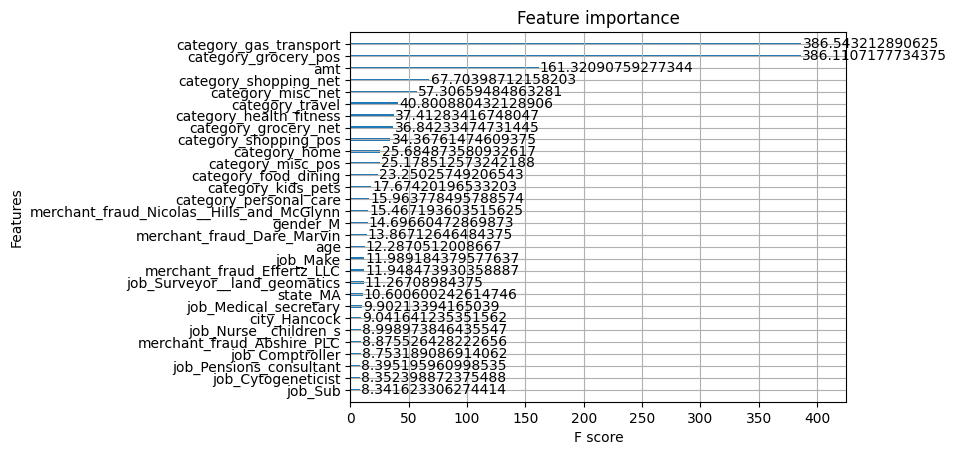

In [11]:
### Feature importance of the model with best results
import xgboost
# Plot feature importance
xgboost.plot_importance(model_6, importance_type='gain', max_num_features=30)  # You can change to 'weight' or 'cover'
plt.show()

## 6 Summary plot with shap

#### Prepare the data

In [4]:
%%time

X_train_encoded_6 = pd.read_parquet('X_train_encoded.csv')
X_test_encoded_6 = pd.read_parquet('X_test_encoded.csv')

# Reset the indices to align them
X_train_encoded_6 = X_train_encoded_6.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Step 1: Separate majority class (0s) and minority class (1s)
X_train_encoded_0 = X_train_encoded_6[y_train == 0]
X_train_encoded_1 = X_train_encoded_6[y_train == 1]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]

# Step 2: Downsample the majority class (0s) by frac
# Downsample X_train_encoded_0 and use its indices to select the corresponding rows from y_train_0
X_train_0_downsampled = X_train_encoded_0.sample(frac=0.5, random_state=42)
y_train_0_downsampled = y_train_0.loc[X_train_0_downsampled.index]  # Use the same indices for y_train

# Step 3: Concatenate the downsampled majority class with the minority class
X_train_downsampled = pd.concat([X_train_0_downsampled, X_train_encoded_1])
y_train_downsampled = pd.concat([y_train_0_downsampled, y_train_1])

# Step 4: Shuffle the dataset to mix the downsampled rows
X_train_downsampled_6 = X_train_downsampled.sample(frac=1, random_state=42)
y_train_downsampled_6 = y_train_downsampled.loc[X_train_downsampled_6.index]

CPU times: total: 3min 19s
Wall time: 2min 55s


In [5]:
# Get all opened DataFrames in the current environment
dfs = [var for var in globals() if isinstance(globals()[var], pd.DataFrame)]

print("List of DataFrames currently in memory:")
print(dfs)

List of DataFrames currently in memory:
['train', 'test', 'X_train', 'X_test', 'X_train_encoded_6', 'X_test_encoded_6', 'X_train_encoded_0', 'X_train_encoded_1', 'X_train_0_downsampled', 'X_train_downsampled', 'X_train_downsampled_6']


In [6]:
del train, test, X_train, X_test, X_train_encoded_6, X_train_encoded_0, X_train_encoded_1, X_train_0_downsampled, X_train_downsampled

#### Run the model

In [7]:
model_6 = XGBClassifier(use_label_encoder=False,
                                          eval_metric='logloss',
                                         max_depth=7, sub_sample=0.9,
                                         learning_rate=0.05, scale_pos_weight=0.8)  

# Step 1: Train the model on the training data
model_6.fit(X_train_downsampled_6, y_train_downsampled_6)

# Step 2: Predict on the training data
y_train_pred = model_6.predict(X_train_downsampled_6)

# Step 3: Predict on the test data
y_test_pred = model_6.predict(X_test_encoded_6)

# Step 4: Generate the classification report for training data
print("Classification Report for Training Data:")
print(classification_report(y_train_downsampled_6, y_train_pred))

# Step 5: Generate the classification report for test data
print("\nClassification Report for Test Data:")
print(classification_report(y_test, y_test_pred))

C:\Users\atans\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:47:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644584
           1       0.87      0.71      0.78      7506

    accuracy                           1.00    652090
   macro avg       0.93      0.85      0.89    652090
weighted avg       1.00      1.00      1.00    652090


Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.68      0.68      0.68      2145

    accuracy                           1.00    555719
   macro avg       0.84      0.84      0.84    555719
weighted avg       1.00      1.00      1.00    555719



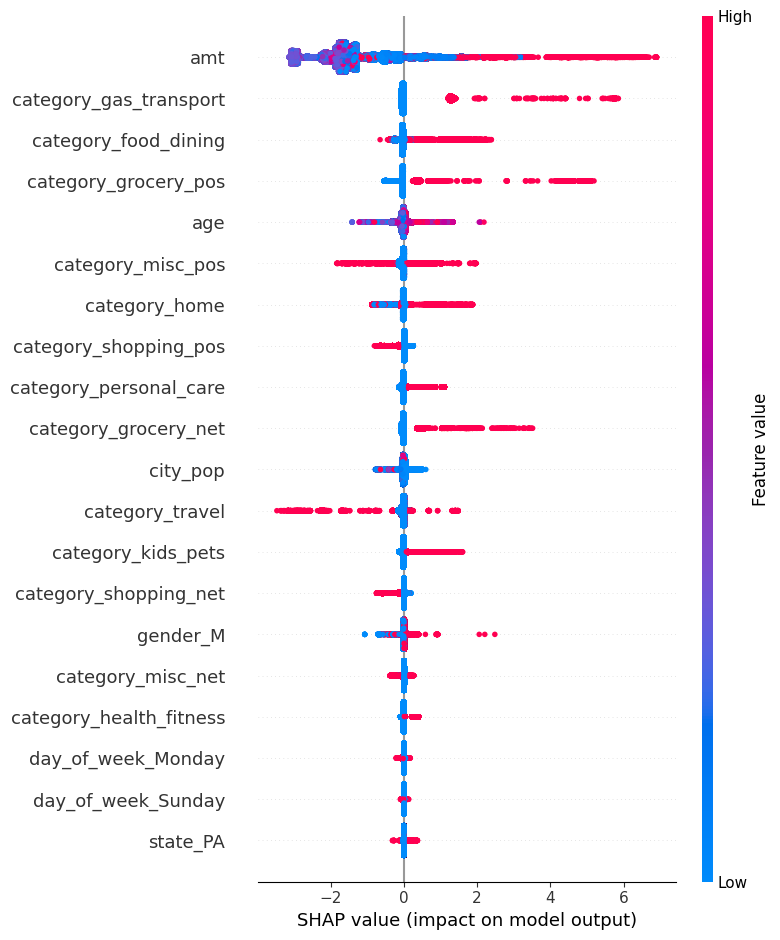

In [9]:
#Use SHAP to explain the model's predictions
explainer = shap.TreeExplainer(model_6)

# Get SHAP values for the test set
shap_values = explainer.shap_values(X_test_encoded_6)

# Plot summary plot (feature importance plot) for top 20 features
shap.summary_plot(shap_values, X_test_encoded_6, max_display=20)